# PubMed articles: Topic Modeling

In [1]:
!git clone https://github.com/LorenaRaichle/ClinIQ.git

Cloning into 'ClinIQ'...
remote: Enumerating objects: 36191, done.
remote: Counting objects: 100% (211/211), done.
remote: Compressing objects: 100% (151/151), done.
remote: Total 36191 (delta 94), reused 174 (delta 58), pack-reused 35980 (from 1)
Receiving objects: 100% (36191/36191), 175.10 MiB | 32.01 MiB/s, done.
Resolving deltas: 100% (12945/12945), done.
Updating files: 100% (126/126), done.


In [2]:
! pip install langchain_pinecone
! pip install pinecone sentence-transformers
! pip install langchain_community
! pip install bertopic
! pip install plotly


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 421.9/421.9 kB 36.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.2/52.2 kB 5.0 MB/s eta 0:00:00
  Attempting uninstall: aiohttp
    Found existing installation: aiohttp 3.11.15
    Uninstalling aiohttp-3.11.15:
      Successfully uninstalled aiohttp-3.11.15
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 129.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 107.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
import sys
!{sys.executable} -m pip install --upgrade bertopic
from datasets import Dataset, DatasetDict
import pprint
import json
import logging
logging.basicConfig(level=logging.DEBUG,  # Set the logging level (DEBUG, INFO, WARNING, ERROR, CRITICAL)
                    format='%(asctime)s - %(levelname)s - %(message)s')  # Define log message format
logger = logging.getLogger(__name__)

import torch
import ast
from collections import Counter
import re
from sentence_transformers import SentenceTransformer

from tqdm import tqdm


from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# PUBMED Topic modeling

### Preprocessing of random sample of 250 k abstracts from 2.5 mio PubMed articles
- check preprocessing of PubMed data in utils/RAG_preprocessing.py
- check notebook 1b_preprocessing RAG for adding "clean_content" field to pubmed entries as preprocessing to Topic Modeling

# Fit a global BERTopic model on all 250 k abstracts

In [6]:
import json

pubmed_data = []
with open("/content/drive/MyDrive/NLP/04_RAG/TopicModeling/PubMed_raw/pubmed_sample_prepro.jsonl", "r") as f:
    for line in f:
        line = line.strip()
        if not line:
            continue
        pubmed_data.append(json.loads(line))

print(f"Loaded {len(pubmed_data)} records")


Loaded 250000 records


In [7]:
test = pubmed_data[:1000]
pubmed_data[0]

{'id': 'pubmed_466957',
 'title': '[Retention of 241Am in the rat and the Syrian hamster].',
 'content': 'The retention of 241-Am during the first three months after injection as well as its microdistribution on the 2nd day were investigated in the rat and the Syrian hamster. Deposition, retention and microdistribution in the skeleton of both species are virtually identical; the same holds for kidneys, except for a higher initial deposition in the hamster. The microdistribution of 241-Am in kidneys and liver of both species is homogenous with a distinct accumulation in the cortical zone of the kidneys. A pronounced difference was observed with regard to the elimination of 241-Am from the liver: Most of the 241-Am is excreted by the rat liver with a half time of 7 days whereas this value is about 150 days for the Syrian hamster. The consequences of the species differences are discussed.',
 'contents': '[Retention of 241Am in the rat and the Syrian hamster]. The retention of 241-Am durin

In [8]:
all_cleaned = [item["clean_content"] for item in pubmed_data]
print(len(all_cleaned))

250000


### Sample & Precompute Embeddings for the 50 k Seed (embedding model: BioClinicalBERT)

In [ ]:
import random, numpy as np
from tqdm import tqdm
from bertopic import BERTopic
from collections import defaultdict
from sentence_transformers import SentenceTransformer, models
import numpy as np
from umap import UMAP
from hdbscan import HDBSCAN

model_name = "emilyalsentzer/Bio_ClinicalBERT"
word_embedding_model = models.Transformer(model_name)
pooling_model = models.Pooling(
    word_embedding_model.get_word_embedding_dimension(),
    pooling_mode_mean_tokens=True,
    pooling_mode_cls_token=False,
    pooling_mode_max_tokens=False
)

embedder = SentenceTransformer(modules=[word_embedding_model, pooling_model])


# randomly pick 50k from 250k cleaned articles
random.seed(42)
seed_indices = random.sample(range(len(all_cleaned)), 50_000)
seed_docs    = [all_cleaned[i] for i in seed_indices]

# compute embeddings for the seed
batch_size = 256
seed_embs = []
for i in tqdm(range(0, len(seed_docs), batch_size), desc="Embedding seed"):
    batch = seed_docs[i : i+batch_size]
    emb   = embedder.encode(batch, show_progress_bar=False)
    seed_embs.append(emb)
seed_embs = np.vstack(seed_embs)  # shape (50k, 768)


Embedding seed: 100%|██████████| 196/196 [02:27<00:00,  1.33it/s]


### Fit BERTopic on the 50 k Seed

In [ ]:
from tqdm import tqdm


#    seed_embs shape: (50k, 768)
umap_model = UMAP(n_neighbors=20, n_components=15, metric="cosine", verbose=True)
hdbscan_model = HDBSCAN(
    min_cluster_size=50,   # get ~50 clusters
    min_samples=15,
    metric="euclidean",
    cluster_selection_method="eom",
    prediction_data=True
)


# UMAP reduction
print("Starting UMAP reduction on seed…")
umap_emb = umap_model.fit_transform(seed_embs)
print("UMAP done.\n")

# HDBSCAN clustering
print("Starting HDBSCAN clustering on UMAP output…")
labels = hdbscan_model.fit_predict(umap_emb)
print("HDBSCAN done. Found", len(set(labels)) - (1 if -1 in labels else 0), "clusters.\n")

# c-TF-IDF topic extraction
print("Extracting topic keywords via c-TF-IDF…")
topic_model = BERTopic(
    embedding_model=embedder,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    nr_topics=50,
    calculate_probabilities=True
)

print("Fitting BERTopic on seed (UMAP → HDBSCAN → c-TF-IDF)…")
seed_topics, seed_probs = topic_model.fit_transform(seed_docs, seed_embs)
print("BERTopic fit complete.")
print(topic_model.get_topic_info().head(10))



Starting UMAP reduction on seed…
UMAP(angular_rp_forest=True, metric='cosine', n_components=15, n_neighbors=20, verbose=True)
Sun May 18 09:04:03 2025 Construct fuzzy simplicial set
Sun May 18 09:04:03 2025 Finding Nearest Neighbors
Sun May 18 09:04:03 2025 Building RP forest with 16 trees
Sun May 18 09:04:08 2025 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	 5  /  16
	Stopping threshold met -- exiting after 5 iterations
Sun May 18 09:04:25 2025 Finished Nearest Neighbor Search
Sun May 18 09:04:28 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Sun May 18 09:04:43 2025 Finished embedding
UMAP done.

Starting HDBSCAN clustering on UMAP output…
HDBSCAN done. Found 27 clusters.

Extracting topic keywords via c-TF-IDF…
Fitting BERTopic on seed (UMAP → HDBSCAN → c-TF-IDF)…
UMAP(angular_rp_forest=True, metric='cosine', n_components=15, n_neighbors=20, verbose=True)
Sun May 18 09:04:51 2025 Construct fuzzy simplicial set
Sun May 18 09:04:51 2025 Finding Nearest Neighbors
Sun May 18 09:04:51 2025 Building RP forest with 16 trees
Sun May 18 09:04:52 2025 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	 5  /  16
	Stopping threshold met -- exiting after 5 iterations
Sun May 18 09:04:55 2025 Finished Nearest Neigh

Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Sun May 18 09:05:09 2025 Finished embedding
BERTopic fit complete.
   Topic  Count                                        Name  \
0     -1  23947                -1_patient_cell_study_effect   
1      0     80                      0_feed_diet_weight_fat   
2      1    126  1_cholesterol_lipoprotein_hdl_triglyceride   
3      2   5788                  2_use_study_health_patient   
4      3    134          3_hormone_level_progesterone_woman   
5      4    346       4_strain_isolate_resistant_resistance   
6      5    318                5_insulin_glucose_min_plasma   
7      6    102           6_cell_electron_granule_structure   
8      7  19159             7_cell_patient_protein_activity   

In [ ]:
# save model for reuse
save_path = "//content/drive/MyDrive/NLP/04_RAG/TopicModeling/NEW_TM/bertopic_model.pkl"
topic_model.save(save_path)
print(f"Model saved to {save_path}")

2025-05-18 09:07:18,837 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.


Sun May 18 09:07:25 2025 Worst tree score: 0.35958000
Sun May 18 09:07:25 2025 Mean tree score: 0.36585875
Sun May 18 09:07:25 2025 Best tree score: 0.37138000
Sun May 18 09:07:28 2025 Forward diversification reduced edges from 1000000 to 378303
Sun May 18 09:07:31 2025 Reverse diversification reduced edges from 378303 to 378303
Sun May 18 09:07:34 2025 Degree pruning reduced edges from 480116 to 473740
Sun May 18 09:07:34 2025 Resorting data and graph based on tree order
Sun May 18 09:07:34 2025 Building and compiling search function
Model saved to //content/drive/MyDrive/NLP/04_RAG/TopicModeling/NEW_TM/bertopic_model


In [ ]:
# saving topic clusters
topic_info_df = topic_model.get_topic_info()
output_csv_path = "/content/drive/MyDrive/NLP/04_RAG/TopicModeling/topic_info.csv"
topic_info_df.to_csv(output_csv_path, index=False)

print(f"Saved topic info (all clusters) to {output_csv_path}")

In [12]:
import pandas as pd
topic_info_50 = pd.read_csv("/content/drive/MyDrive/NLP/04_RAG/TopicModeling/NEW_TM/topic_info.csv")
topic_info_50 = topic_info_50[topic_info_50.Topic != -1]
topic_info_50.head()

,Topic,Count,Name,Representation,Representative_Docs
1,0,126,0_cholesterol_lipoprotein_hdl_triglyceride,"['cholesterol', 'lipoprotein', 'hdl', 'triglyc...",['desogestrel gestodene oral contraceptive mon...
2,1,167,1_cell_electron_structure_fiber,"['cell', 'electron', 'structure', 'fiber', 'gr...",['ultrastructure adrenal medulla normal insuli...
3,2,149,2_hormone_progesterone_level_estrogen,"['hormone', 'progesterone', 'level', 'estrogen...",['hormonal response patient polycystic ovarian...
4,3,73,3_feed_diet_rat_fat,"['feed', 'diet', 'rat', 'fat', 'weight', 'inta...",['effect amino acid imbalance protein content ...
5,4,395,4_strain_isolate_resistant_resistance,"['strain', 'isolate', 'resistant', 'resistance...",['resistance pseudomona aeruginosa chloramphen...


### Score All 250 k Docs Against the Seed‐Learned Topics

In [ ]:
# transform to get full (250k × T) probabilities
full_topics, full_probs = topic_model.transform(seed_docs, seed_embs)

In [ ]:

all_assignments = []
for idx, (tid, prob_row) in enumerate(zip(full_topics, full_probs)):
    all_assignments.append({
        "id":          pubmed_data[idx]["id"],
        "assigned_topic": int(tid),
        "confidence":  float(prob_row[tid])
    })


with open("/content/drive/MyDrive/NLP/04_RAG/TopicModeling/all_250k_topic_assignments.jsonl", "w") as out:
    for rec in all_assignments:
       out.write(json.dumps(rec) + "\n")

print("Saved full 250k assignments to all_250k_topic_assignments.jsonl")




### filter 15 k

In [ ]:
import numpy as np

# clarity metrics
max_probs = full_probs.max(axis=1)
sorted_p  = np.sort(full_probs, axis=1)
margins   = sorted_p[:, -1] - sorted_p[:, -2]

# high‐quality mask
conf_thr   = 0.6
margin_thr = 0.2
mask = (max_probs >= conf_thr) & (margins >= margin_thr)

# filter down
hq_indices = np.where(mask)[0]
print(f"Kept {len(hq_indices)} / {len(all_cleaned)} docs after clarity filtering")


from collections import defaultdict
hq_ids_by_topic = defaultdict(list)
for idx in hq_indices:
    tid = str(full_topics[idx])
    hq_ids_by_topic[tid].append({
        "id":          pubmed_data[idx]["id"],
        "confidence":  float(max_probs[idx])
    })

# compute per-topic quota
total = 15_000
T     = len(hq_ids_by_topic)
base  = total // T

diverse = []
leftovers = []
for tid, recs in hq_ids_by_topic.items():
    recs_sorted = sorted(recs, key=lambda r: r["confidence"], reverse=True)
    pick = recs_sorted[:base]
    diverse.extend(pick)
    leftovers.extend(recs_sorted[base:])


need = total - len(diverse)
if need > 0:
    leftovers = sorted(leftovers, key=lambda r: r["confidence"], reverse=True)
    diverse.extend(leftovers[:need])

print(f"Final diverse set: {len(diverse)} docs across {T} topics")


Kept 11321 / 250000 docs after clarity filtering
Final diverse set: 11321 docs across 27 topics


In [ ]:
rag_seed = []
for tid, recs in hq_ids_by_topic.items():
    for r in recs:
        rag_seed.append({
            "id":         r["id"],
            "topic_id":   int(tid),
            "confidence": r["confidence"]
        })

output_path = "/content/drive/MyDrive/NLP/04_RAG/TopicModeling/rag_seed_15k.jsonl"
with open(output_path, "w") as out:
    for rec in rag_seed:
        out.write(json.dumps(rec) + "\n")

print(f"Saved your 15k RAG seed to {output_path}")

# this file is now tm_diverse_15k

Saved your 15k RAG seed to /content/drive/MyDrive/NLP/04_RAG/TopicModeling/rag_seed_15k.jsonl


### how many docs have been assigned to each topic?

In [ ]:
df = pd.DataFrame(rag_seed)

dist = (
    df.groupby("topic_id")
      .size()
      .reset_index(name="doc_count")
      .sort_values("doc_count", ascending=False)
)

dist

,topic_id,doc_count
14,13,4837
10,9,2225
25,24,788
26,25,462
11,10,364
19,18,249
0,-1,232
12,11,188
5,4,182
21,20,176


In [ ]:
df['topic_id'].nunique()

27

# Topic Modeling done --> for 15 / 11 k articles extract key phrases for pinecone embedding

In [ ]:
! pip install keybert


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 1.8 MB/s eta 0:00:00


In [ ]:
seed = []
# now file: tm_diverse_15k.jsonl
with open("/content/drive/MyDrive/NLP/04_RAG/TopicModeling/TM_NEW/rag_seed_15k.jsonl","r") as f:
    for line in f:
        seed.append(json.loads(line))

# lookup from id → clean_content
pubmed_lookup = { rec["id"]: rec["clean_content"] for rec in pubmed_data }

# reusing your embedder
kw_model  = KeyBERT(model=embedder)


for rec in seed:
    cid   = rec["id"]
    text  = pubmed_lookup[cid]
    rec["clean_content"] = text

    # extract keyphrases
    kws = kw_model.extract_keywords(
      text,
      keyphrase_ngram_range=(1,2),
      stop_words="english",
      top_n=5,
      use_mmr=True,
      diversity=0.7
    )
    rec["keyphrases"] = [p for p,_ in kws]

    # embed the joined keyphrases
    joined = "; ".join(rec["keyphrases"])
    rec["kp_embedding"] = embedder.encode(joined).tolist()


with open("/content/drive/MyDrive/NLP/04_RAG/TopicModeling/rag_seed_15k_enriched.jsonl","w") as out:
    for rec in seed:
        out.write(json.dumps(rec) + "\n")

print("Wrote enriched RAG seed to rag_seed_15k_enriched.jsonl")

Wrote enriched RAG seed to rag_seed_15k_enriched.jsonl


In [ ]:
from sentence_transformers import SentenceTransformer

records = []
with open("/content/drive/MyDrive/NLP/04_RAG/TopicModeling/rag_seed_15k_enriched.jsonl") as f:
    for line in f:
        records.append(json.loads(line))

# same model as for pinecone index for embedding (dimension 1024)
bge = SentenceTransformer("BAAI/bge-large-en-v1.5")

# keyphrases embedded
for rec in tqdm(records, desc="Re-embedding keyphrases to 1024-d"):
    joined = "; ".join(rec["keyphrases"])
    rec["kp_embedding"] = bge.encode(joined).tolist()


with open("/content/drive/MyDrive/NLP/04_RAG/TopicModeling/rag_seed_15k_enriched_1024d.jsonl", "w") as out:
    for rec in records:
        out.write(json.dumps(rec) + "\n")


# adding PubMed data to PINECONE

In [26]:
from google.colab import userdata
from pinecone import Pinecone, ServerlessSpec

import sys
import os
from pathlib import Path
%cd /content/ClinIQ

sys.path.append(os.getcwd())
from config import INDEX_NAME

#sys.path.append(str(Path(".").resolve()))
from utils.RAG_metadata import extract_keywords_and_entities, extract_age_gender
from utils.RAG_pinecone import init_index, RAGIndexer
from pathlib import Path
import os


pinecone_key = userdata.get("PINECONE")
pc = Pinecone(api_key=pinecone_key, environment="us-west1-gcp")

index = init_index(pc)

/content/ClinIQ


/usr/local/lib/python3.11/dist-packages/spacy/util.py:910: UserWarning: [W095] Model 'en_ner_bc5cdr_md' (0.5.4) was trained with spaCy v3.7.4 and may not be 100% compatible with the current version (3.8.6). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)
/usr/local/lib/python3.11/dist-packages/spacy/language.py:2232: FutureWarning: Possible set union at position 6328
  deserializers["tokenizer"] = lambda p: self.tokenizer.from_disk(  # type: ignore[union-attr]


ℹ Index 'rag-trainset-index' already exists.


In [ ]:
# loading 15 k extracted and embedded key phrases for representative sample
records = []
with open("/content/drive/MyDrive/NLP/04_RAG/TopicModeling/rag_seed_15k_enriched_1024d.jsonl") as f:
    for line in f:
        records.append(json.loads(line))

In [ ]:


vectors_to_upsert = []
counter = 0
index = pc.Index(index_name)
for rec in tqdm(records, desc="Preparing upsert"):

    pine_id = str(counter)
    counter += 1

    vector = rec["kp_embedding"]

    metadata = {
        "id":     rec["id"],
        "topic_id":   rec["topic_id"],
        "confidence": rec["confidence"],
        "page_content": rec["id"]
    }

    vectors_to_upsert.append((pine_id, vector, metadata))

for i in tqdm(range(0, len(vectors_to_upsert), 100), desc="Upserting"):
    batch = vectors_to_upsert[i : i + 100]
    index.upsert(vectors=batch)

print(f"Upserted {len(vectors_to_upsert)} vectors.")


Upserting: 100%|██████████| 114/114 [01:00<00:00,  1.88it/s]

Upserted 11316 vectors.


In [ ]:
index.describe_index_stats()


{'dimension': 1024,
 'index_fullness': 0.0,
 'metric': 'cosine',
 'namespaces': {'': {'vector_count': 411857}},
 'total_vector_count': 411857,
 'vector_type': 'dense'}

# visualization of topics

In [ ]:
import pandas as pd

df = pd.read_csv("/content/drive/MyDrive/NLP/04_RAG/TopicModeling/NEW_TM/topic_info.csv")
df

,Topic,Count,Name,Representation,Representative_Docs
0,-1,37665,-1_cell_patient_study_effect,"['cell', 'patient', 'study', 'effect', 'increa...",['protein alpha subunit alter morphology growt...
1,0,126,0_cholesterol_lipoprotein_hdl_triglyceride,"['cholesterol', 'lipoprotein', 'hdl', 'triglyc...",['desogestrel gestodene oral contraceptive mon...
2,1,167,1_cell_electron_structure_fiber,"['cell', 'electron', 'structure', 'fiber', 'gr...",['ultrastructure adrenal medulla normal insuli...
3,2,149,2_hormone_progesterone_level_estrogen,"['hormone', 'progesterone', 'level', 'estrogen...",['hormonal response patient polycystic ovarian...
4,3,73,3_feed_diet_rat_fat,"['feed', 'diet', 'rat', 'fat', 'weight', 'inta...",['effect amino acid imbalance protein content ...
5,4,395,4_strain_isolate_resistant_resistance,"['strain', 'isolate', 'resistant', 'resistance...",['resistance pseudomona aeruginosa chloramphen...
6,5,282,5_glucose_insulin_min_05,"['glucose', 'insulin', 'min', '05', 'plasma', ...",['effect gemfibrozil treatment sulfonylurea tr...
7,6,72,6_age_birth_woman_weight,"['age', 'birth', 'woman', 'weight', 'risk', 'b...",['management extremely low birth weight infant...
8,7,54,7_patient_pressure_antihypertensive_effect,"['patient', 'pressure', 'antihypertensive', 'e...",['use nifedipine postpartum period patient sev...
9,8,64,8_measurement_method_use_result,"['measurement', 'method', 'use', 'result', 'an...",['computer program calculate mean skin tempera...


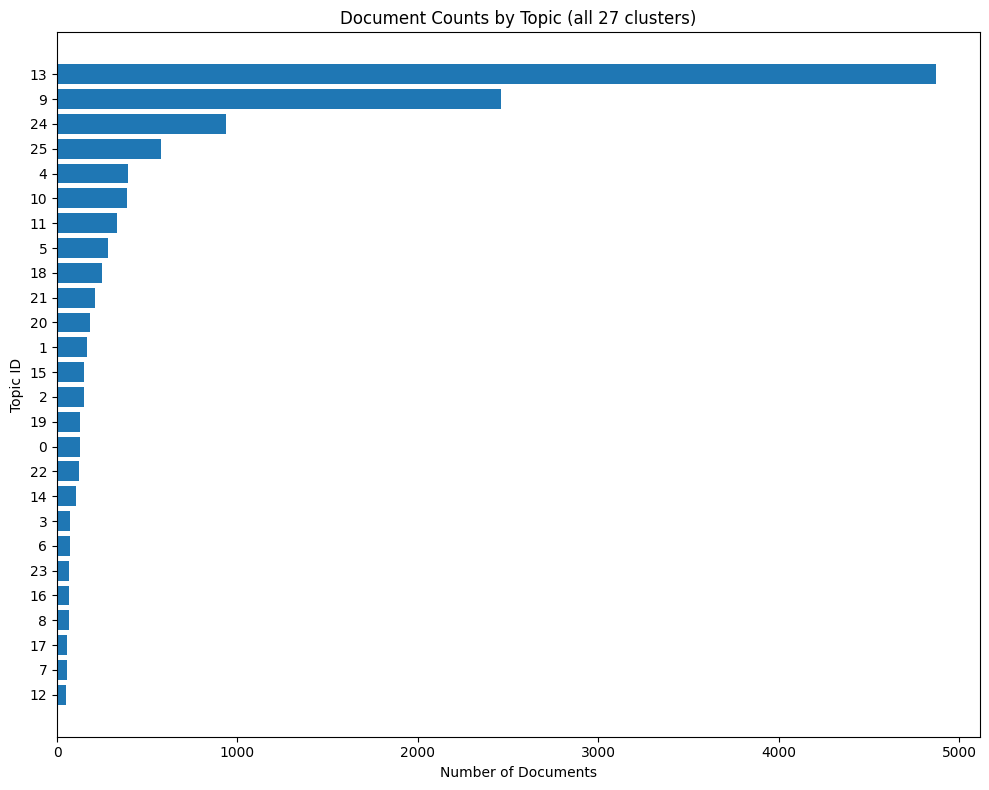

In [ ]:
df = df[df.Topic != -1]

df = df.sort_values("Count", ascending=False)

# plot all 27 topics
plt.figure(figsize=(10, 8))
plt.barh(
    y = df.Topic.astype(str),  # topic ID on x axis
    width = df.Count
)
plt.gca().invert_yaxis()
plt.xlabel("Number of Documents")
plt.ylabel("Topic ID")
plt.title("Document Counts by Topic (all 27 clusters)")
plt.tight_layout()
plt.show()

In [ ]:
import json

path = "/content/drive/MyDrive/NLP/04_RAG/TopicModeling/NEW_TM/rag_seed_15k_enriched_1024d.jsonl"
records = []
with open(path, "r") as f:
    for line in f:
        line = line.strip()
        if not line:
            continue
        records.append(json.loads(line))

print(f"Loaded {len(records)} records")
print("First record:", records[0])


Loaded 11321 records
First record: {'id': 'pubmed_124979', 'topic_id': 0, 'confidence': 0.9999999984338656, 'clean_content': 'fistula ano year follow study 143 operate patient 143 patient operate anal fistulae heal satisfactorally impair healing patient high fistulae operate modify elting repair patient suffer crohn disease internal opening localize fistula lay open excised healing place case method cause incontinence high fistulae method use loop suture technique satisfoactory result regard healing anal control follow modify elting repair case recurrence believe method value leave sphincter intact', 'keyphrases': ['technique satisfoactory', 'intact', 'patient', 'follow', '143'], 'kp_embedding': [0.006665709428489208, 0.014262586832046509, -0.026651594787836075, 0.04137717932462692, -0.06332214176654816, -0.037869445979595184, 0.00552708376199007, 0.03893578425049782, 0.04316595569252968, 0.019426031038165092, 0.015247935429215431, 0.043245695531368256, 0.016201524063944817, -0.0091192

In [ ]:

topic_info  = topic_model.get_topic_info()
real_topics = [t for t in topic_info.Topic.tolist() if t != -1]
n_topics    = len(real_topics)

print(n_topics)


fig_all = topic_model.visualize_topics(top_n_topics=n_topics)
fig_all.show()

fig_bar = topic_model.visualize_barchart(top_n_topics=n_topics)
fig_bar.show()


fig_tree = topic_model.visualize_hierarchy(topics=real_topics)
fig_tree.show()


fig_heat = topic_model.visualize_heatmap(topics=real_topics,
                                         top_n_topics=n_topics)
fig_heat.show()


8


In [ ]:
# 2) UMAP scatter of all topics
fig_topics = topic_model.visualize_topics()
fig_topics.show()

# 3) Bar chart of topic sizes (top N by default)
fig_barchart = topic_model.visualize_barchart(top_n_topics=27)  # show all 27
fig_barchart.show()

# 4) Hierarchical clustering dendrogram
fig_hierarchy = topic_model.visualize_hierarchy()
fig_hierarchy.show()

# 5) Topic correlation heatmap
fig_heatmap = topic_model.visualize_heatmap()
fig_heatmap.show()



ModuleNotFoundError: No module named 'bertopic.debug'

In [ ]:
num_topics = topic_model.get_topic_info().shape[0] - 1

# 3) UMAP scatter of all topics
fig_topics = topic_model.visualize_topics()
fig_topics.show()

# 4) Bar chart of topic sizes (show all topics)
fig_barchart = topic_model.visualize_barchart(top_n_topics=num_topics)
fig_barchart.show()

# 5) Hierarchical clustering dendrogram
fig_hierarchy = topic_model.visualize_hierarchy()
fig_hierarchy.show()

# 6) Topic correlation heatmapho
fig_heatmap = topic_model.visualize_heatmap()
fig_heatmap.show()